<a href="https://colab.research.google.com/github/Rakhi0402/PhishNet-Deep-Learning-Based-Email-Phishing-Predictor/blob/main/Phishing_model_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/phishing_email.csv")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

df = df[['text_combined', 'label']].dropna()
df['label'] = df['label'].astype(int)

train_texts, remaining_texts, train_labels, remaining_labels = train_test_split(
    df['text_combined'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    remaining_texts, remaining_labels, test_size=0.5, stratify=remaining_labels, random_state=42)

Dataset shape: (82486, 2)

First 5 rows:
                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0


In [ ]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    tokens = tokenizer(batch['text_combined'], padding='max_length', truncation=True, max_length=512)
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}

train_ds = Dataset.from_dict({'text_combined': train_texts.tolist(), 'label': train_labels.tolist()})
val_ds = Dataset.from_dict({'text_combined': val_texts.tolist(), 'label': val_labels.tolist()})
test_ds = Dataset.from_dict({'text_combined': test_texts.tolist(), 'label': test_labels.tolist()})

train_ds = train_ds.map(tokenize, batched=True).remove_columns(['text_combined'])
val_ds = val_ds.map(tokenize, batched=True).remove_columns(['text_combined'])
test_ds = test_ds.map(tokenize, batched=True).remove_columns(['text_combined'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/65988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8249 [00:00<?, ? examples/s]

Map:   0%|          | 0/8249 [00:00<?, ? examples/s]

In [ ]:
# Load Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

print(model.config)
# Training Configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none"
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.050000,0.038564,0.990908,0.991272,0.989775,0.992774


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.050000,0.038564,0.990908,0.991272,0.989775,0.992774
2,0.006200,0.051548,0.992484,0.992792,0.990260,0.995338
3,0.013300,0.029752,0.994787,0.994987,0.995335,0.994639


{'eval_loss': 0.02975158579647541,
 'eval_accuracy': 0.9947872469390229,
 'eval_f1': 0.9949865920485018,
 'eval_precision': 0.9953347329134593,
 'eval_recall': 0.9946386946386946,
 'eval_runtime': 114.3953,
 'eval_samples_per_second': 72.11,
 'eval_steps_per_second': 9.021,
 'epoch': 3.0}

In [ ]:
history = trainer.state.log_history

In [ ]:
trainer.save_model("./Phishing_model_DistilBERT")
tokenizer.save_pretrained("./Phishing_model_DistilBERT")
!cp -r ./Phishing_model_DistilBERT /content/drive/MyDrive/

Test Results: {'eval_loss': 0.04318903386592865, 'eval_accuracy': 0.9926051642623348, 'eval_f1': 0.9928796544881522, 'eval_precision': 0.9941561477325853, 'eval_recall': 0.9916064350664491, 'eval_runtime': 114.313, 'eval_samples_per_second': 72.162, 'eval_steps_per_second': 9.028, 'epoch': 3.0}
              precision    recall  f1-score   support

  Legitimate     0.9909    0.9937    0.9923      3960
    Phishing     0.9942    0.9916    0.9929      4289

    accuracy                         0.9926      8249
   macro avg     0.9925    0.9926    0.9926      8249
weighted avg     0.9926    0.9926    0.9926      8249



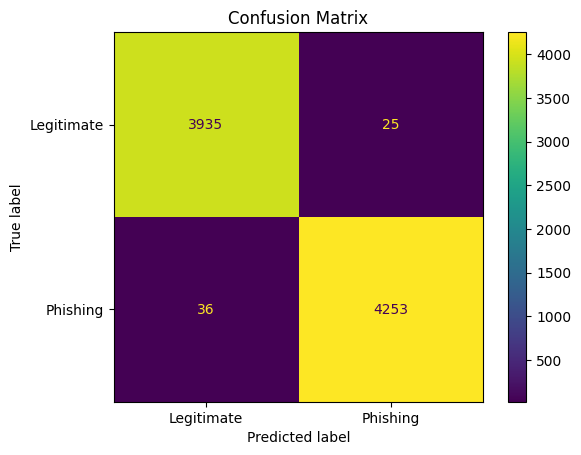

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):
       global train_accuracy
       labels = pred.label_ids
       preds = np.argmax(pred.predictions, axis=1)
       precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
       acc = accuracy_score(labels, preds)
       train_accuracy.append(acc)
       return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

results = trainer.evaluate(eval_dataset=test_ds)
print("Test Results:", results)

preds = trainer.predict(test_ds)
predicted_labels = preds.predictions.argmax(-1)
target_names = ['Legitimate', 'Phishing']

report = classification_report(preds.label_ids, predicted_labels, target_names=target_names, digits=4)
print(report)

cm = confusion_matrix(preds.label_ids, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, pipeline
import pandas as pd

model_path = "/content/drive/MyDrive/Phishing_model_DistilBERT"

model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

new_emails = pd.read_csv("/content/Book1.csv")

predictions = []
for email in new_emails['text_combined']:
    prediction = classifier(email, truncation=True, max_length=512)
    predictions.append(prediction[0]['label'])

new_emails["prediction"] = predictions

print(new_emails)

new_emails.to_csv("/content/drive/MyDrive/predicted_emails.csv", index=False)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                         text_combined prediction
0     mr tim chapman freelance gentleman of letters...    LABEL_0
1    smith graham computing technician wrote URL th...    LABEL_0
2    geege wrote a strange story i know a guy who i...    LABEL_0
3     paul moore but let s walk before we run after...    LABEL_0
4    on mon nov NUMBER NUMBER at NUMBER NUMBER NUMB...    LABEL_0
..                                                 ...        ...
104   drywall your home refinance loan is approved ...    LABEL_1
105  dear sir madam if you are fed up of being ripp...    LABEL_1
106   diversified underwriters services inc impaire...    LABEL_1
107   guaranteed to increase lift and firm your bre...    LABEL_1
108  attn president from mrs helina karimu i am an ...    LABEL_1

[109 rows x 2 columns]
